In [1]:
# import standard libraries #
from dataclasses import dataclass
import itertools
import random
import time
from typing import Any

# import 3rd party packages #
from matplotlib import pyplot as plt
import matplotlib.lines
import numpy as np
import scipy.sparse
import sklearn.base
import sklearn.datasets
import sklearn.discriminant_analysis
import sklearn.ensemble
import sklearn.feature_extraction
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.neural_network
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.tree
import sklearn.compose
import tensorflow_hub
import xgboost

# Specify Training Parameters

In [2]:
@dataclass
class trainConfig:
    """Specifies training process settings"""

    k_cross_valid_folds: int = 10  # number of cross-validation folds
    use_n_cores: int = (
        6  # passed to n_jobs arg of sklearn.model_selection.cross_validate
    )
    train_undersample_frac: float = (
        0.5  # I only used 50% of the training data because I was sick of waiting for models to finish training
    )


training_config: trainConfig = trainConfig()

# Import Data

In [3]:
# import the data #
train_data_dict = sklearn.datasets.fetch_20newsgroups(
    subset="train",
    shuffle=True,
    random_state=69,
    remove=("headers", "footers", "quotes"),
    # return_X_y=True,
)

test_data_dict = sklearn.datasets.fetch_20newsgroups(
    subset="test",
    shuffle=True,
    random_state=69,
    remove=("headers", "footers", "quotes"),
    # return_X_y=True,
)

label_encoder = sklearn.preprocessing.LabelEncoder()

n_train_samples = int(
    len(train_data_dict["data"]) * training_config.train_undersample_frac
)
x_train = train_data_dict["data"][:n_train_samples]
x_test = test_data_dict["data"]

y_labels_train = [
    train_data_dict["target_names"][y_idx]
    for y_idx in train_data_dict["target"][:n_train_samples]
]
y_labels_test = [
    test_data_dict["target_names"][y_idx] for y_idx in test_data_dict["target"]
]

label_encoder.fit(y_labels_train)
y_codes_train = label_encoder.transform(y_labels_train)
y_codes_test = label_encoder.transform(y_labels_test)

del train_data_dict, test_data_dict

In [4]:
# look at a random example #
random_idx = random.randint(0, len(x_train))
print("<", y_labels_train[random_idx], ">")
print(x_train[random_idx])

< rec.autos >


Having spoken to technical staff from Ford many times, I can assure you that 
internally at Ford this car is always called the Taurus "Show" or just  
"the Show".  As in long "o" sound.  I still refer to it as the "S-H-O",
however, because it sounds better to me. I assume many purist fans and owners 
prefer using the Ford lingo.  


# Feature Engineering

In [5]:
# specify tokenization strategy for bag-of-words (n-gram) features #
tokenizer = sklearn.feature_extraction.text.CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    ngram_range=(1, 3),
    max_features=10_000,  # only use the top "max_features" features
    max_df=0.1,  # don't consider n-grams more common that this
)

# create bag-of-words (n-gram) features #
tokenizer.fit(x_train)
x_train_bag_of_words: scipy.sparse._csr.csr_matrix = tokenizer.transform(x_train)
x_test_bag_of_words: scipy.sparse._csr.csr_matrix = tokenizer.transform(x_test)

In [6]:
# load document embedding model #
universal_sentence_encoder = tensorflow_hub.load(
    "https://tfhub.dev/google/universal-sentence-encoder/4"
)

# create document embeddings #
x_train_embeddings: np.ndarray = universal_sentence_encoder(x_train).numpy()
x_test_embeddings: np.ndarray = universal_sentence_encoder(x_test).numpy()

In [7]:
# combine bag-of-words and embeddings into a single dataset #
# this requires the (dense) embeddings to be converted to a sparse matrix #
# (this seemed wiser than converting the very sparse data to dense) #
x_train_embeddings_sparse = scipy.sparse.csr_matrix(x_train_embeddings)
x_train_bagofwords_and_embeddings_sparse = scipy.sparse.hstack(
    (x_train_bag_of_words, x_train_embeddings_sparse)
)

# Specify Experiments to Run

In [8]:
# specify models to fit #
models: dict[str, Any] = {
    "adaboost": sklearn.ensemble.AdaBoostClassifier(),
    "decision_tree": sklearn.tree.DecisionTreeClassifier(),
    "extremely_random_trees": sklearn.ensemble.ExtraTreesClassifier(),
    # "gbm": sklearn.ensemble.GradientBoostingClassifier(), # too slow
    # "hist_gbm": HistGradientBoostingClassifier(), # doesn't support sparse X
    "logistic_regression": sklearn.linear_model.LogisticRegression(
        penalty=None,
        max_iter=1_000,
    ),
    # "naive_bayes": sklearn.naive_bayes.MultinomialNB(), # requires non-negative X
    "neural_net": sklearn.neural_network.MLPClassifier(
        hidden_layer_sizes=(50, 30, 10, 10), activation="relu", max_iter=5_000
    ),
    # "qda": sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis(), # doesn't support sparse X
    "random_forest": sklearn.ensemble.RandomForestClassifier(),
    "xg_boost": xgboost.XGBClassifier(objective="multi:softmax"),
}

models["stacked_ensemble"] = sklearn.ensemble.StackingClassifier(
    estimators=[
        (
            model_name,
            sklearn.base.clone(models[model_name]),
        )
        for model_name in models.keys()
    ],
    final_estimator=xgboost.XGBClassifier(objective="multi:softmax"),
    cv=5,
    stack_method="predict_proba",
    n_jobs=1,
    passthrough=False,  # False=train final_estimator on estimators preds only (i.e. exclude original covariates)
)

# specify datasets to fit #
datasets_to_fit: list[str] = [
    "bag_of_words_only",
    "embeddings_only",
    "bag_of_words_and_embeddings",
]

# list out all model/dataset combinations #
experiments_to_run = tuple(itertools.product(datasets_to_fit, models.keys()))
print("-- All Experiments To Run --")
for experiment_num, experiment_contents in enumerate(experiments_to_run):
    dataset_name, model_name = experiment_contents
    print(
        f"experiment_id=[{experiment_num}]  dataset=[{dataset_name}], model=[{model_name}]"
    )

-- All Experiments To Run --
experiment_id=[0]  dataset=[bag_of_words_only], model=[adaboost]
experiment_id=[1]  dataset=[bag_of_words_only], model=[decision_tree]
experiment_id=[2]  dataset=[bag_of_words_only], model=[extremely_random_trees]
experiment_id=[3]  dataset=[bag_of_words_only], model=[logistic_regression]
experiment_id=[4]  dataset=[bag_of_words_only], model=[neural_net]
experiment_id=[5]  dataset=[bag_of_words_only], model=[random_forest]
experiment_id=[6]  dataset=[bag_of_words_only], model=[xg_boost]
experiment_id=[7]  dataset=[bag_of_words_only], model=[stacked_ensemble]
experiment_id=[8]  dataset=[embeddings_only], model=[adaboost]
experiment_id=[9]  dataset=[embeddings_only], model=[decision_tree]
experiment_id=[10]  dataset=[embeddings_only], model=[extremely_random_trees]
experiment_id=[11]  dataset=[embeddings_only], model=[logistic_regression]
experiment_id=[12]  dataset=[embeddings_only], model=[neural_net]
experiment_id=[13]  dataset=[embeddings_only], model=[ra

The metric calculated in each holdout fold in order to evaluate overall model performance on that fold is called [roc_auc_ovr](https://scikit-learn.org/stable/modules/model_evaluation.html).

This metric is generated by calculating a [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) score for each unique class (using a [one-vs-rest](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#one-vs-rest-multiclass-roc) approach), and then taking a macro-average (unweighted mean) over these scores to obtain a single final [roc_auc_ovr](https://scikit-learn.org/stable/modules/model_evaluation.html) score.

Note that this approach may be a bad idea if there is severe class-imbalance in the data, and can also hide poor model performance on specific classes.

# Run k-Fold Cross Validation

(to identify the best-performing model(s) and feature engineering strategy)

In [9]:
# run k-fold cross-validation on all model/dataset combinations #
k_fold_cv_results: dict[str, Any] = {}
for experiment_num, experiment_contents in enumerate(experiments_to_run):
    start_time = time.perf_counter()
    dataset_name, model_name = experiment_contents
    print(
        f"""
    Running experiment        {experiment_num}
    Dataset:                  {dataset_name}
    Model:                    {model_name} 
"""
    )
    match dataset_name:
        case "bag_of_words_only":
            temp_x: scipy.sparse._csr.csr_matrix = x_train_bag_of_words
        case "embeddings_only":
            temp_x: np.ndarray = x_train_embeddings
        case "bag_of_words_and_embeddings":
            temp_x: scipy.sparse._csr.csr_matrix = (
                x_train_bagofwords_and_embeddings_sparse
            )
    k_fold_cv_results[
        (model_name, dataset_name)
    ] = sklearn.model_selection.cross_validate(
        estimator=sklearn.base.clone(models[model_name]),
        X=temp_x,
        y=y_codes_train,
        scoring="roc_auc_ovr",  # see https://scikit-learn.org/stable/modules/model_evaluation.html
        cv=training_config.k_cross_valid_folds,
        return_train_score=False,
        return_estimator=False,
        n_jobs=training_config.use_n_cores,
    )
    minutes_elapsed = (time.perf_counter() - start_time) / 60
    test_score_per_label = k_fold_cv_results[(model_name, dataset_name)].get(
        "test_score"
    )
    print(
        "   Scores on holdout folds: "
        + f"(mean={np.mean(test_score_per_label):.3f}) (min={min(test_score_per_label):.3f}) (max={max(test_score_per_label):.3f}) scores: "
        + ", ".join([f"{test_score:.2f}" for test_score in test_score_per_label])
    )
    print(f"    ...done ({minutes_elapsed:.2f} minutes)")


    Running experiment        0
    Dataset:                  bag_of_words_only
    Model:                    adaboost 

   Scores on holdout folds: (mean=0.740) (min=0.731) (max=0.750) scores: 0.73, 0.74, 0.75, 0.75, 0.74, 0.73, 0.74, 0.74, 0.75, 0.74
    ...done (0.06 minutes)

    Running experiment        1
    Dataset:                  bag_of_words_only
    Model:                    decision_tree 

   Scores on holdout folds: (mean=0.720) (min=0.702) (max=0.739) scores: 0.72, 0.72, 0.72, 0.74, 0.73, 0.70, 0.73, 0.70, 0.71, 0.72
    ...done (0.07 minutes)

    Running experiment        2
    Dataset:                  bag_of_words_only
    Model:                    extremely_random_trees 

   Scores on holdout folds: (mean=0.931) (min=0.912) (max=0.942) scores: 0.94, 0.91, 0.93, 0.93, 0.93, 0.93, 0.94, 0.94, 0.93, 0.94
    ...done (0.19 minutes)

    Running experiment        3
    Dataset:                  bag_of_words_only
    Model:                    logistic_regression 

   Sc

/Users/josephbolton/personal_projects/sklearn-text-classifier-pipeline/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josephbolton/personal_projects/sklearn-text-classifier-pipeline/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation

   Scores on holdout folds: (mean=0.930) (min=0.917) (max=0.939) scores: 0.93, 0.92, 0.93, 0.93, 0.93, 0.92, 0.93, 0.93, 0.93, 0.94
    ...done (0.52 minutes)

    Running experiment        12
    Dataset:                  embeddings_only
    Model:                    neural_net 

   Scores on holdout folds: (mean=0.914) (min=0.902) (max=0.927) scores: 0.92, 0.91, 0.92, 0.92, 0.93, 0.91, 0.90, 0.91, 0.90, 0.92
    ...done (0.32 minutes)

    Running experiment        13
    Dataset:                  embeddings_only
    Model:                    random_forest 

   Scores on holdout folds: (mean=0.941) (min=0.928) (max=0.947) scores: 0.94, 0.93, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.95
    ...done (0.41 minutes)

    Running experiment        14
    Dataset:                  embeddings_only
    Model:                    xg_boost 

   Scores on holdout folds: (mean=0.953) (min=0.944) (max=0.958) scores: 0.96, 0.94, 0.95, 0.96, 0.95, 0.95, 0.95, 0.96, 0.95, 0.95
    ...done (17.17 mi

/Users/josephbolton/personal_projects/sklearn-text-classifier-pipeline/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josephbolton/personal_projects/sklearn-text-classifier-pipeline/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation

   Scores on holdout folds: (mean=0.952) (min=0.941) (max=0.960) scores: 0.95, 0.94, 0.96, 0.96, 0.95, 0.95, 0.96, 0.96, 0.95, 0.95
    ...done (117.50 minutes)

    Running experiment        16
    Dataset:                  bag_of_words_and_embeddings
    Model:                    adaboost 

   Scores on holdout folds: (mean=0.795) (min=0.765) (max=0.820) scores: 0.80, 0.79, 0.81, 0.77, 0.80, 0.79, 0.82, 0.78, 0.80, 0.79
    ...done (1.22 minutes)

    Running experiment        17
    Dataset:                  bag_of_words_and_embeddings
    Model:                    decision_tree 

   Scores on holdout folds: (mean=0.697) (min=0.676) (max=0.710) scores: 0.70, 0.70, 0.70, 0.71, 0.71, 0.68, 0.68, 0.71, 0.69, 0.69
    ...done (0.42 minutes)

    Running experiment        18
    Dataset:                  bag_of_words_and_embeddings
    Model:                    extremely_random_trees 

   Scores on holdout folds: (mean=0.929) (min=0.918) (max=0.940) scores: 0.94, 0.92, 0.93, 0.94, 0.93, 

In [10]:
# calculate summary statistics for each model/dataset combination cross-validation result #
for key, value in k_fold_cv_results.items():
    value["mean_test_score"] = value["test_score"].mean()
    value["min_test_score"] = value["test_score"].min()
    value["max_test_score"] = value["test_score"].max()

# sort results by mean test score #
k_fold_cv_results = {
    k: v
    for k, v in sorted(
        k_fold_cv_results.items(),
        key=lambda item: item[1].get("mean_test_score"),
        reverse=True,
    )
}

# Plot k-Fold Cross-Validation Performance for each Experiment

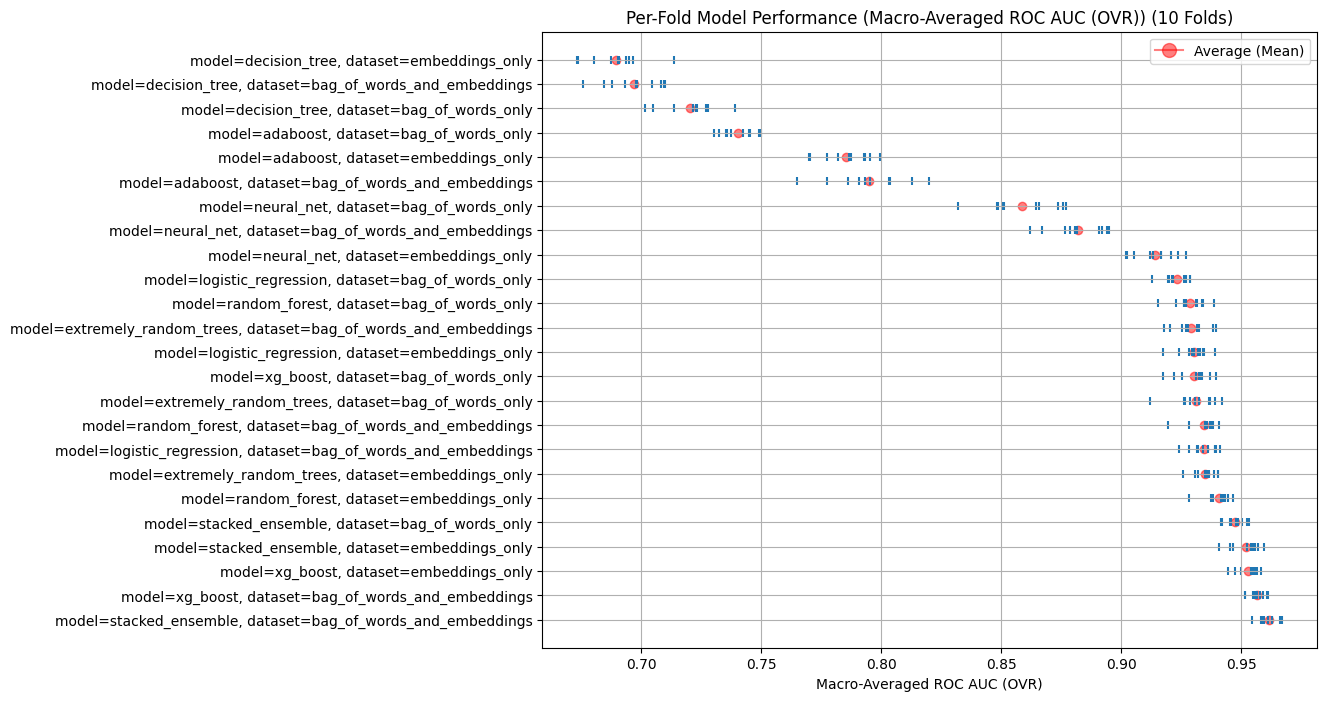

In [11]:
plt.figure(figsize=(10, 8))
# draw in each group mean #
plt.scatter(
    y=[f"model={key[0]}, dataset={key[1]}" for key in k_fold_cv_results.keys()],
    x=[value.get("mean_test_score") for value in k_fold_cv_results.values()],
    color="red",
    alpha=0.5,
)
# draw in performance on each fold #
plt.scatter(
    y=tuple(
        itertools.chain.from_iterable(
            [
                [f"model={key[0]}, dataset={key[1]}"] * trainConfig.k_cross_valid_folds
                for key in k_fold_cv_results.keys()
            ]
        )
    ),
    x=tuple(
        itertools.chain.from_iterable(
            [value.get("test_score").tolist() for value in k_fold_cv_results.values()]
        )
    ),
    marker="|",
)
plt.xlabel("Macro-Averaged ROC AUC (OVR)")
plt.grid()
plt.title(
    f"Per-Fold Model Performance (Macro-Averaged ROC AUC (OVR)) ({training_config.k_cross_valid_folds} Folds)"
)
# draw legend #
plt.legend(
    handles=[
        matplotlib.lines.Line2D(
            [0],
            [0],
            marker="o",
            color="red",
            alpha=0.5,
            label="Average (Mean)",
            markerfacecolor="red",
            markersize=10,
        ),
    ]
)

# Train Final Chosen Model

In [12]:
final_model = models.get("stacked_ensemble")
final_model.fit(X=x_train_bagofwords_and_embeddings_sparse, y=y_codes_train)

StackingClassifier(cv=5,
                   estimators=[('adaboost', AdaBoostClassifier()),
                               ('decision_tree', DecisionTreeClassifier()),
                               ('extremely_random_trees',
                                ExtraTreesClassifier()),
                               ('logistic_regression',
                                LogisticRegression(max_iter=1000,
                                                   penalty=None)),
                               ('neural_net',
                                MLPClassifier(hidden_layer_sizes=(50, 30, 10,
                                                                  10),
                                              max_iter=5000)),
                               ('random_forest', RandomForestClassifier...
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 objective='multi:softmax',
                                                 predictor=None, ...),
                   n_jobs=1, stack_method='predict_proba')

# Create Prediction Pipeline

(contains both feature engineering and trained model within a single useable/saveable/loadable scikit-learn **pipeline** object)

In [13]:
# create model prediction pipeline #
embedder = sklearn.preprocessing.FunctionTransformer(
    lambda x: universal_sentence_encoder(x), feature_names_out="one-to-one"
)
prediction_pipeline = sklearn.pipeline.Pipeline(
    steps=[
        (
            "feature_prep",
            sklearn.pipeline.FeatureUnion(
                [("bag_of_words", tokenizer), ("document_embedding", embedder)]
            ),
        ),
        ("model", final_model),
    ]
)

# Evaluate Final Model on Test Data

In [14]:
# get predictions on test data #
test_pred_codes = prediction_pipeline.predict(X=x_test)
test_preds_proba = prediction_pipeline.predict_proba(X=x_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'alt.atheism'),
  Text(1, 0, 'comp.graphics'),
  Text(2, 0, 'comp.os.ms-windows.misc'),
  Text(3, 0, 'comp.sys.ibm.pc.hardware'),
  Text(4, 0, 'comp.sys.mac.hardware'),
  Text(5, 0, 'comp.windows.x'),
  Text(6, 0, 'misc.forsale'),
  Text(7, 0, 'rec.autos'),
  Text(8, 0, 'rec.motorcycles'),
  Text(9, 0, 'rec.sport.baseball'),
  Text(10, 0, 'rec.sport.hockey'),
  Text(11, 0, 'sci.crypt'),
  Text(12, 0, 'sci.electronics'),
  Text(13, 0, 'sci.med'),
  Text(14, 0, 'sci.space'),
  Text(15, 0, 'soc.religion.christian'),
  Text(16, 0, 'talk.politics.guns'),
  Text(17, 0, 'talk.politics.mideast'),
  Text(18, 0, 'talk.politics.misc'),
  Text(19, 0, 'talk.religion.misc')])

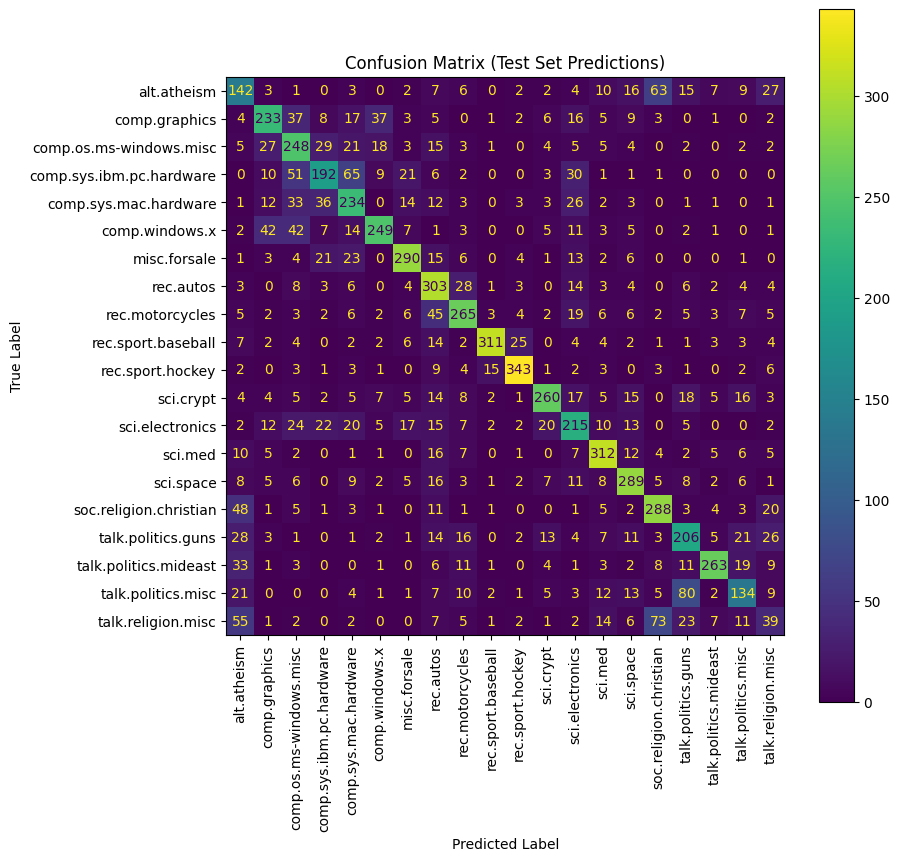

In [15]:
# plot confusion matrix on test data #
# fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix: np.ndarray = sklearn.metrics.confusion_matrix(
    y_true=y_codes_test, y_pred=test_pred_codes
)
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix, display_labels=label_encoder.classes_
)
confusion_matrix_display.plot()
fig = confusion_matrix_display.ax_.get_figure()
fig.set_figwidth(9)
fig.set_figheight(9)
plt.title("Confusion Matrix (Test Set Predictions)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)

Text(0, 0.5, 'Model Accuracy / % of Total Data')

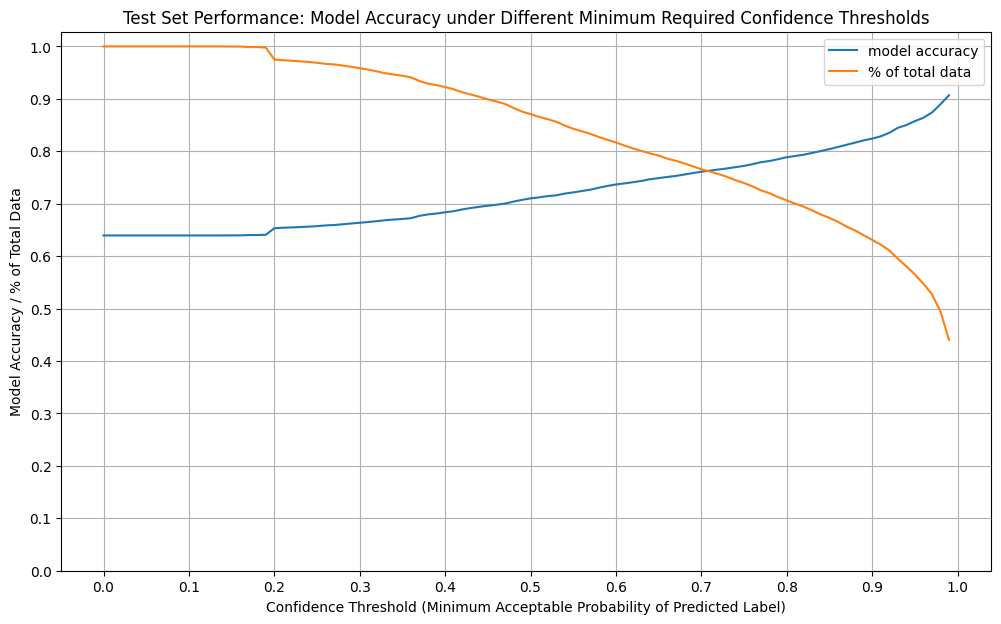

In [16]:
# plot model test set performance (accuracy) for different confidence thresholds #
# i.e. if we consider model predictions with a low probability value as "model doesn't know",
#       then what accuracy can we achieve over only "high confidence" predictions
#       (and for what proportion of the data do we have "high confidence" predictions)
test_max_pred_proba = test_preds_proba.max(axis=1)
prob_thresholds = np.arange(test_preds_proba.min(), test_preds_proba.max(), 0.01)
test_accuracy: list[float] = []
percent_of_obs: list[float] = []
for prob_thresh in prob_thresholds:
    idx_mask = test_max_pred_proba > prob_thresh
    temp_y_true = y_codes_test[idx_mask]
    temp_y_pred = test_pred_codes[idx_mask]
    test_accuracy.append((temp_y_pred == temp_y_true).sum() / len(temp_y_true))
    percent_of_obs.append(idx_mask.sum() / len(test_max_pred_proba))
plt.figure(figsize=(12, 7))
plt.plot(prob_thresholds, test_accuracy, label="model accuracy")
plt.plot(prob_thresholds, percent_of_obs, label="% of total data")
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.grid()
plt.legend()
plt.title(
    "Test Set Performance: Model Accuracy under Different Minimum Required Confidence Thresholds"
)
plt.xlabel("Confidence Threshold (Minimum Acceptable Probability of Predicted Label)")
plt.ylabel("Model Accuracy / % of Total Data")